# EDA + CenterNet Baseline

References:
* Took 3D visualization code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car
* CenterNet paper https://arxiv.org/pdf/1904.07850.pdf
* CenterNet repository https://github.com/xingyizhou/CenterNet

# What is this competition about?
1. You are given the images taken from the roof of a car
    * ~4k training images
    * Always the same car and the same camera
2. You are asked to detect other cars on that image
    * There can be many cars
    * You need to predict their positions
![](https://i.ibb.co/7RJ2Wbs/results-33-2.png)

## What is in this notebook?
* Data distributions: 1D, 2D and 3D
* Functions to transform between camera coordinates and road coordinates
* Simple CenterNet baseline

## CenterNet
This architecture predicts centers of objects as a heatmap.  
It predicts sizes of the boxes as a regression task.  
![](https://github.com/xingyizhou/CenterNet/raw/master/readme/fig2.png)

It is also used for pose estimation:
![](https://raw.githubusercontent.com/xingyizhou/CenterNet/master/readme/pose3.png)
*(images from the [original repository](https://github.com/xingyizhou/CenterNet))*  
Coordinates of human joints are also predicted using regression.  

I use this idea to predict `x, y, z` coordinates of the vehicle and also `yaw, pitch_cos, pitch_sin, roll` angles.  
For `pitch` I predict sin and cos, because, as we will see, this angle can be both near 0 and near 3.14.  
These 7 parameters are my regression target variables instead of `shift_x, shift_y, size_x, size_y`.  

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '/home/hy/pkuad/'
os.listdir(PATH)

['camera',
 'model_1229_b5.pth',
 'predictions_b5_1229.csv',
 'pediction-resnet34-epoch24-loss 4.34-sz-2050x0.5.csv',
 'train_masks',
 '.ipynb_checkpoints',
 'b0_sz-2052-1026.pth',
 'car_models_json',
 'train.csv',
 'model.pth',
 'b5_sz-2052-1026.pth',
 'train_images',
 'test_masks',
 'test_images',
 'center-resnet34-trial.ipynb',
 'hourglass_module-sz-512x512-epoch16-loss-0.1654.csv',
 'car_models',
 'centernet-objects-as-points.ipynb',
 'predictions_resnet34_0.54.csv',
 'center-resnet-trial-bk.ipynb',
 'sample_submission.csv',
 'centernet_weights.hdf5',
 'notebook',
 'resnet34-sz-2052-1026.pth',
 'predictions_resnet.csv',
 'centernet-baseline-b0.ipynb',
 'model_resnet.pth',
 'csv.ipynb',
 'resnet34-sz-2052-1026.csv']

# Load data

In [2]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
bad_list = ['ID_1a5a10365',
'ID_1db0533c7',
'ID_53c3fe91a',
'ID_408f58e9f',
'ID_4445ae041',
'ID_bb1d991f6',
'ID_c44983aeb',
'ID_f30ebe4d4']
train = train.loc[~train['ImageId'].isin(bad_list)]

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

**ImageId** column contains names of images:

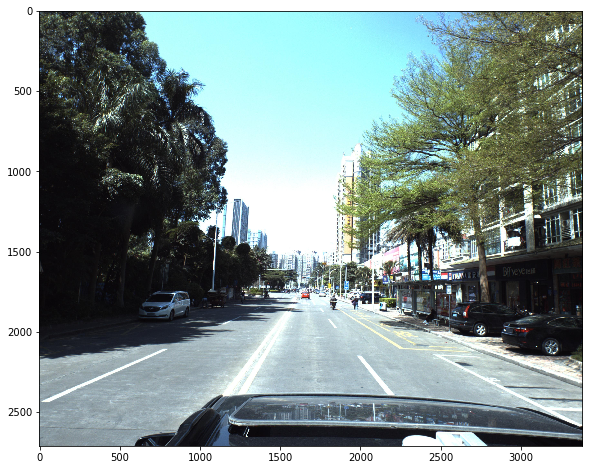

In [3]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

**PredictionString** column contains pose information about all cars  

From the data description:
> The primary data is images of cars and related pose information. The pose information is formatted as strings, as follows:  
>
> `model type, yaw, pitch, roll, x, y, z`  
>
> A concrete example with two cars in the photo:  
>
> `5 0.5 0.5 0.5 0.0 0.0 0.0 32 0.25 0.25 0.25 0.5 0.4 0.7`  

We will need a function to extract these values:

In [4]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [5]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# Data distributions

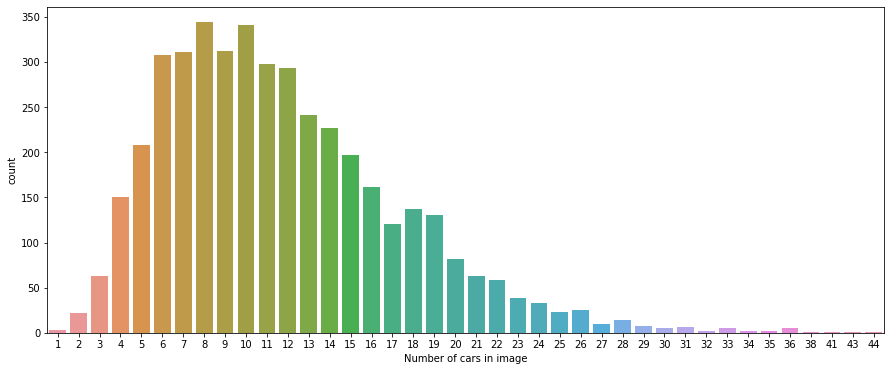

In [6]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

plt.figure(figsize=(15,6))
sns.countplot(lens);
plt.xlabel('Number of cars in image');

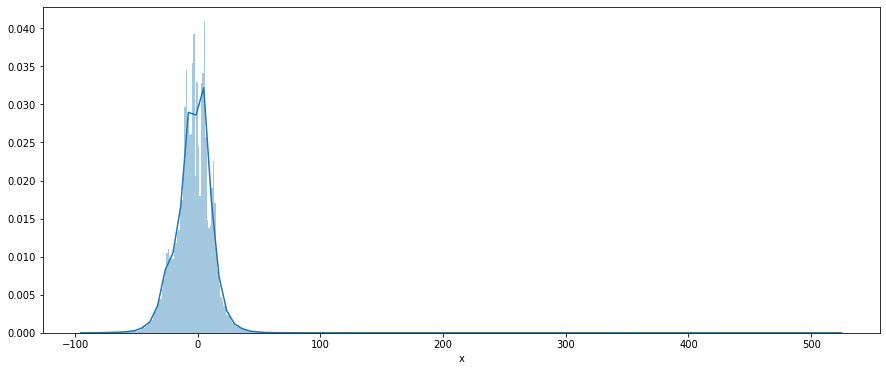

In [7]:
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['x'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
# sns.distplot([str2coords(s)[0]['x'] for s in train['PredictionString']]);
plt.xlabel('x')
plt.show()

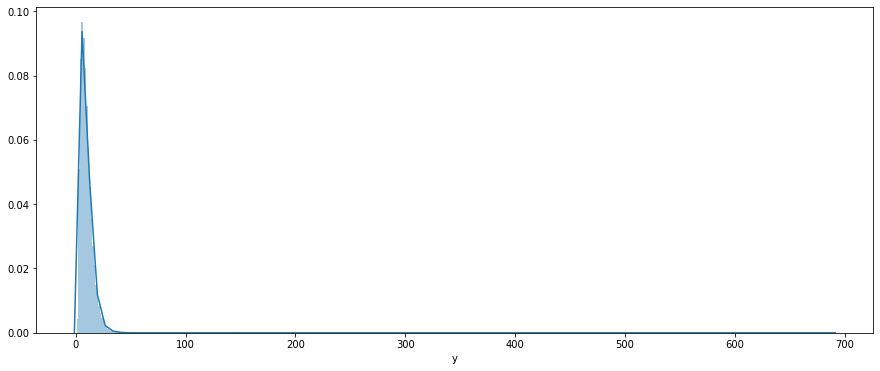

In [8]:
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['y'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
plt.xlabel('y')
plt.show()

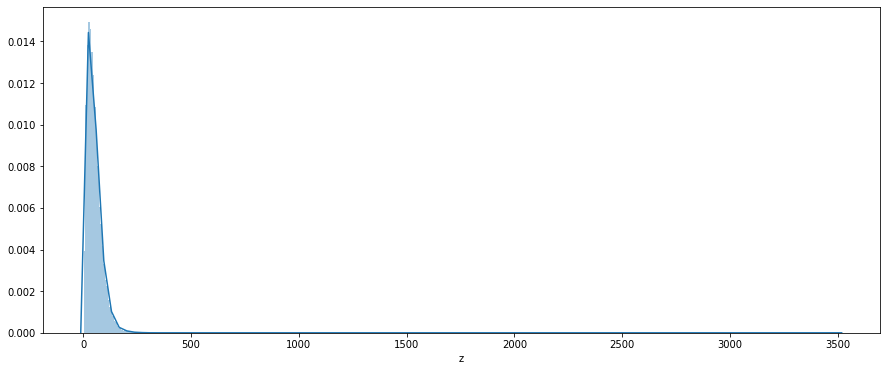

In [9]:
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['z'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
plt.xlabel('z')
plt.show()

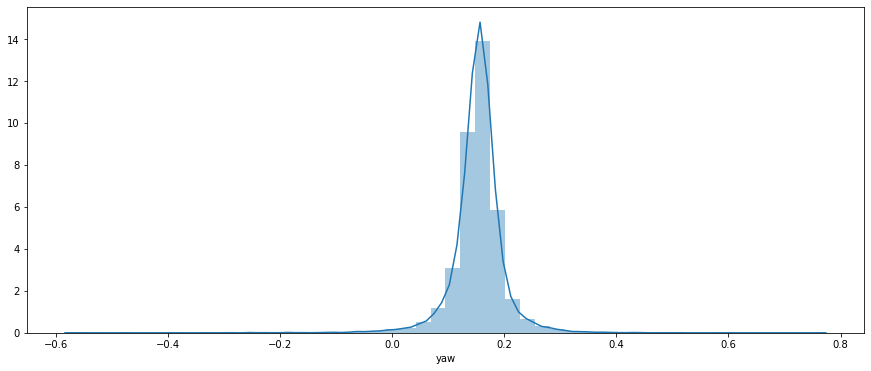

In [10]:
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['yaw'] for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('yaw')
plt.show()

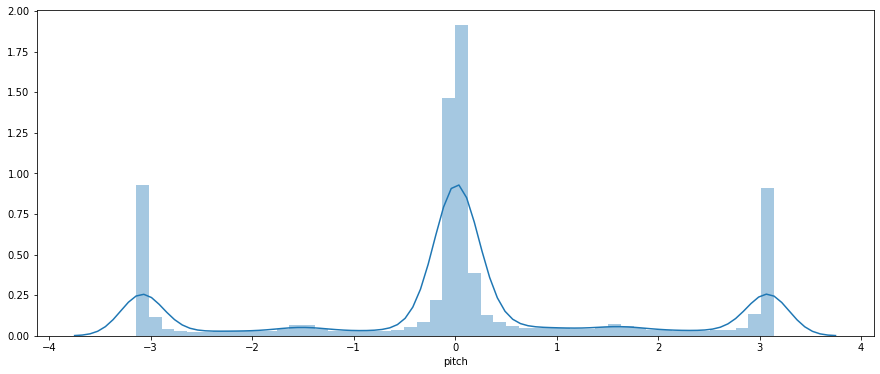

In [11]:
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['pitch'] for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('pitch')
plt.show()

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

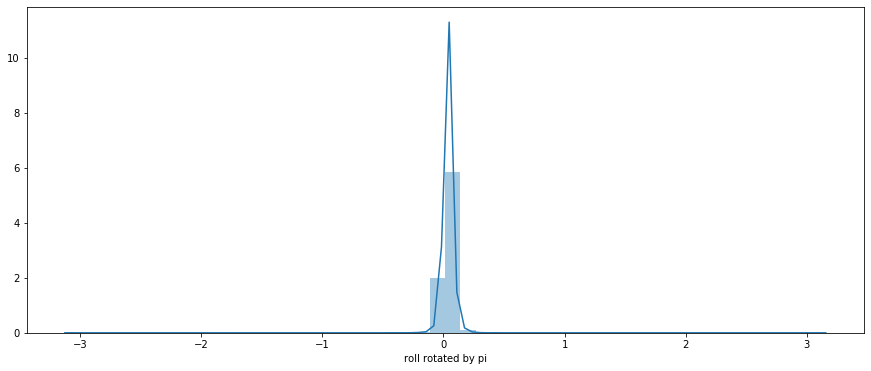

In [12]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('roll rotated by pi')
plt.show()

# 2D Visualization

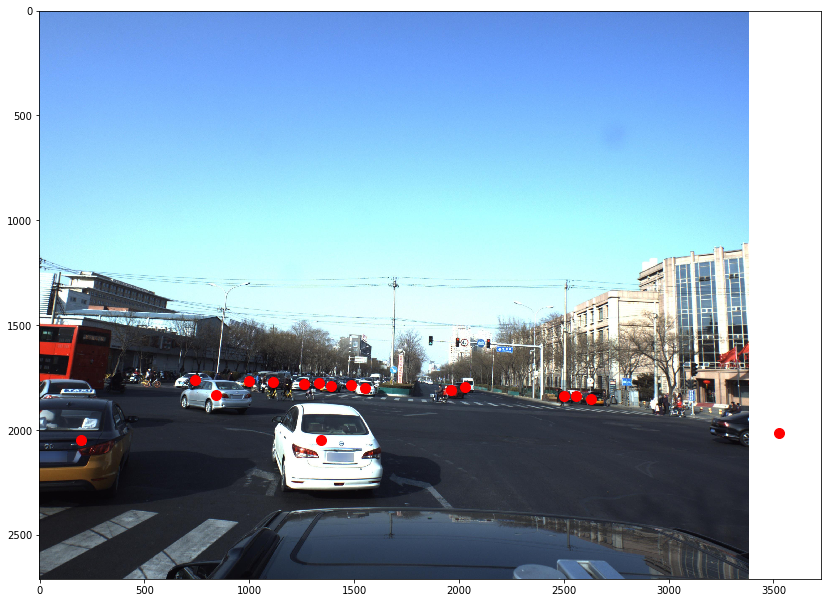

In [13]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

One point is out of image!

Let's look at the distribution of all points. Image is here just for reference.

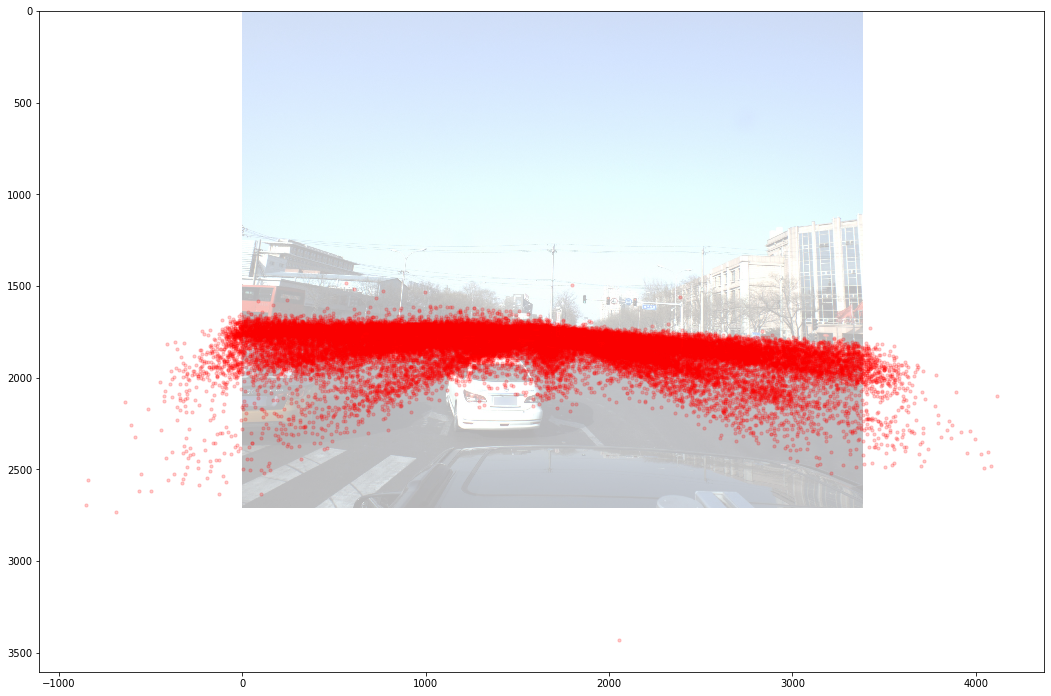

In [14]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

Many points are outside!

Let's look at this distribution "from the sky"

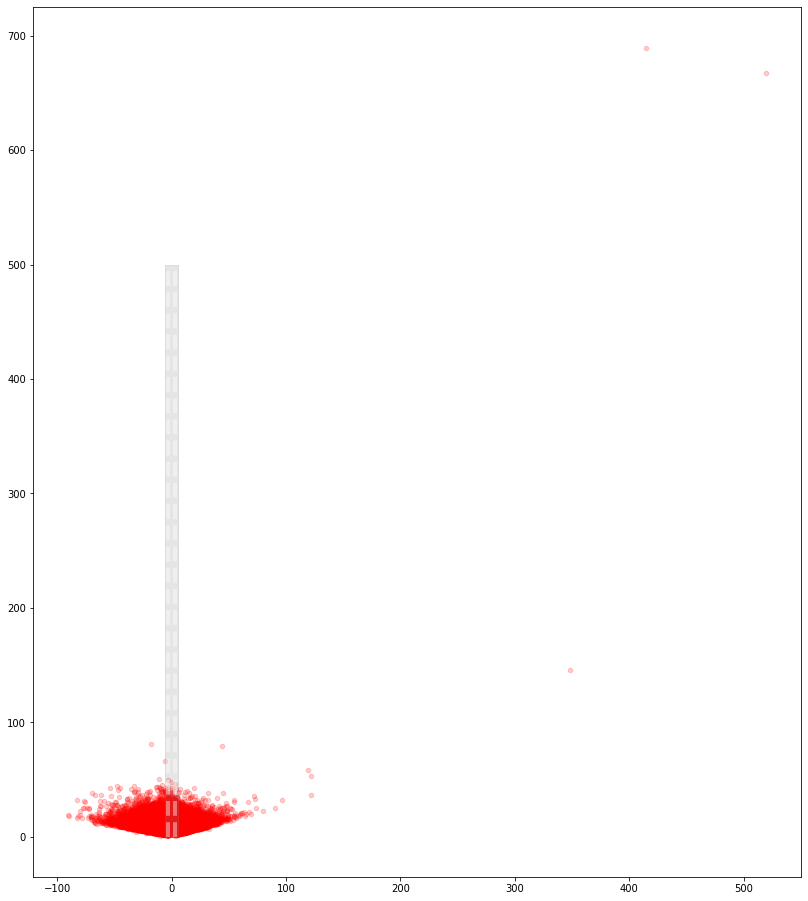

In [15]:
# Cars points
xs, ys = [], []
for ps in train['PredictionString']:
    coords = str2coords(ps)
    xs += [c['x'] for c in coords]
    ys += [c['y'] for c in coords]

# Road points
road_width = 6
road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
road_ys = [0, 0, 500, 500, 0]

plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,500], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,500], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(xs, ys, color='red', s=20, alpha=0.2);

Some points are very far away

Scale up

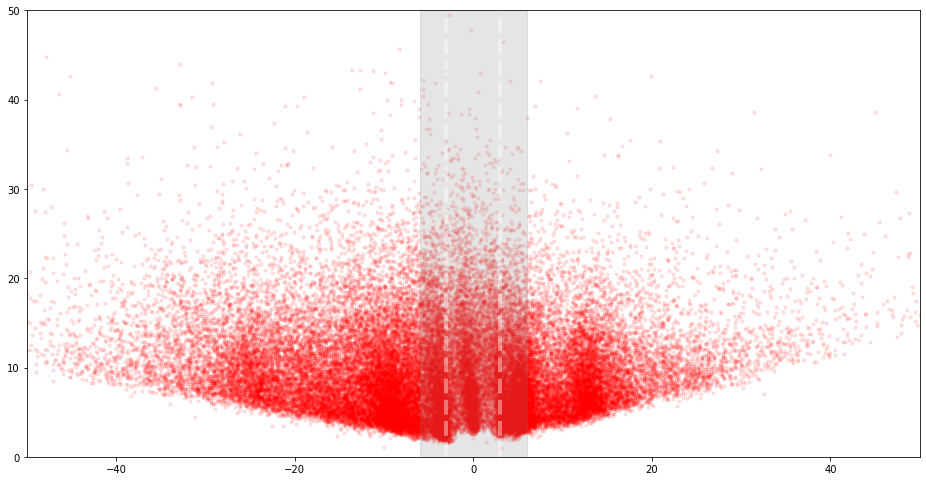

In [16]:
plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
plt.xlim(-50,50)
plt.ylim(0,50)

# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(xs, ys, color='red', s=10, alpha=0.1);

# 3D Visualization
Used code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, but made it one function

In [17]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [18]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [19]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

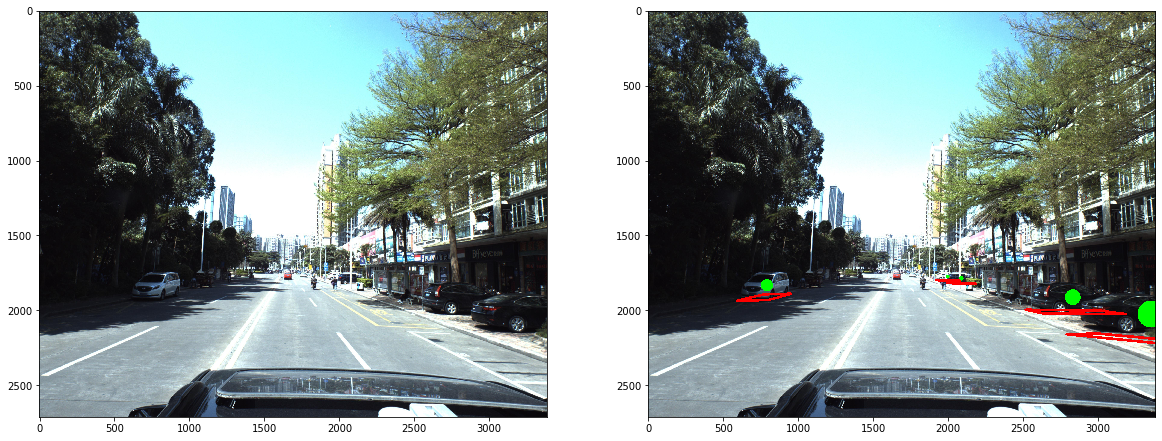

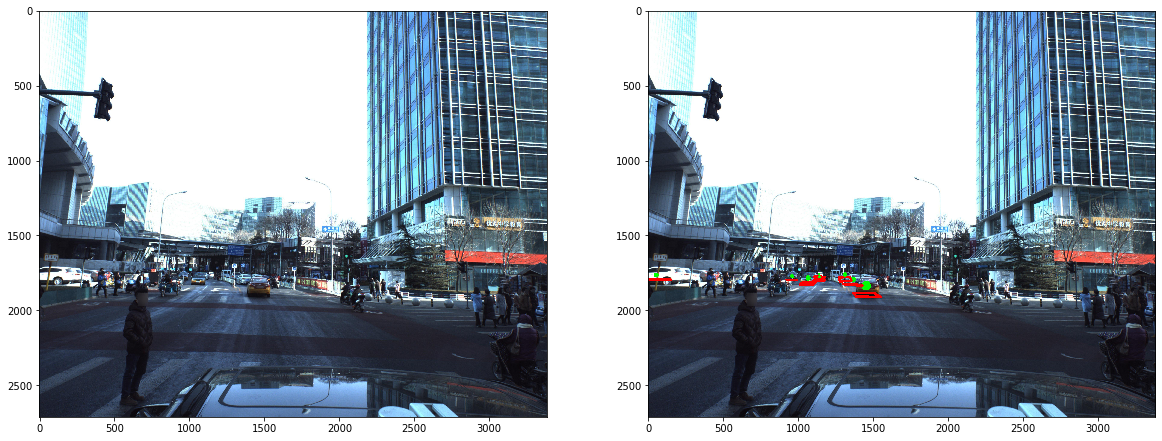

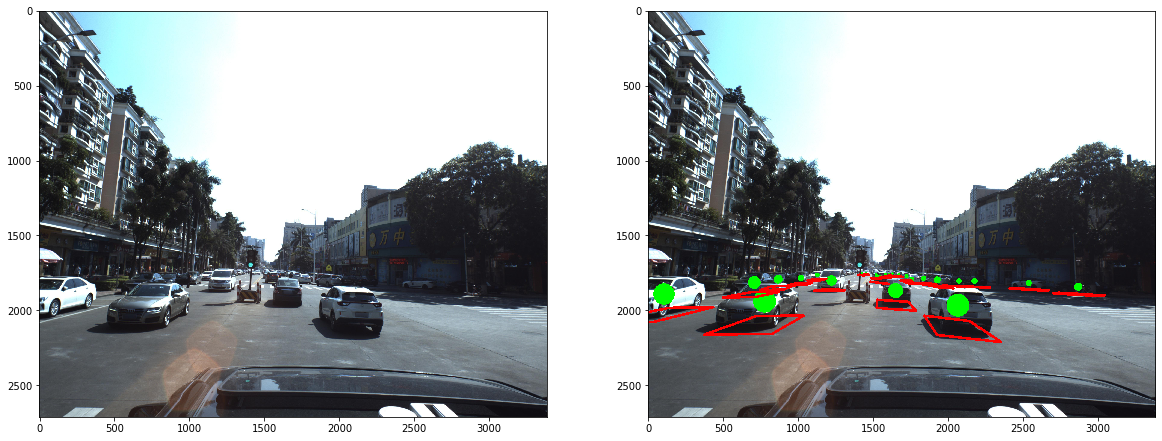

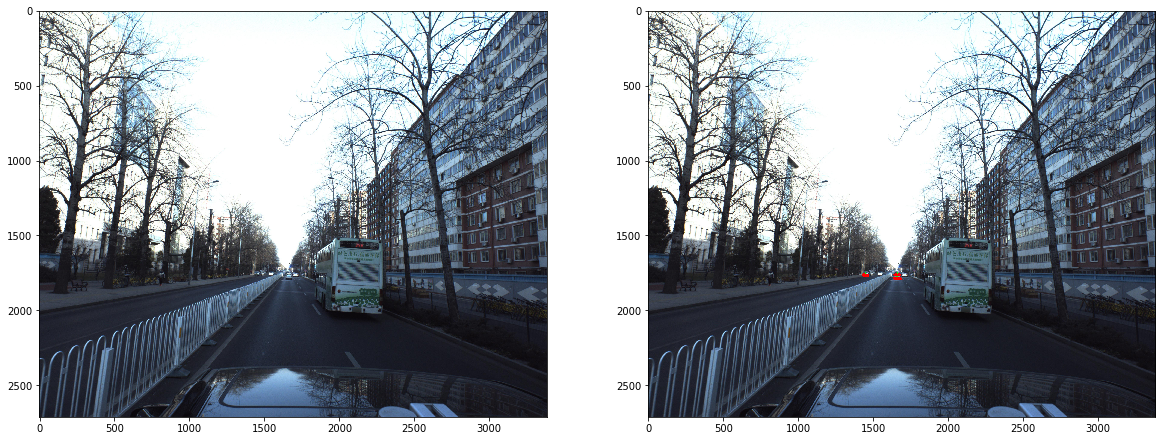

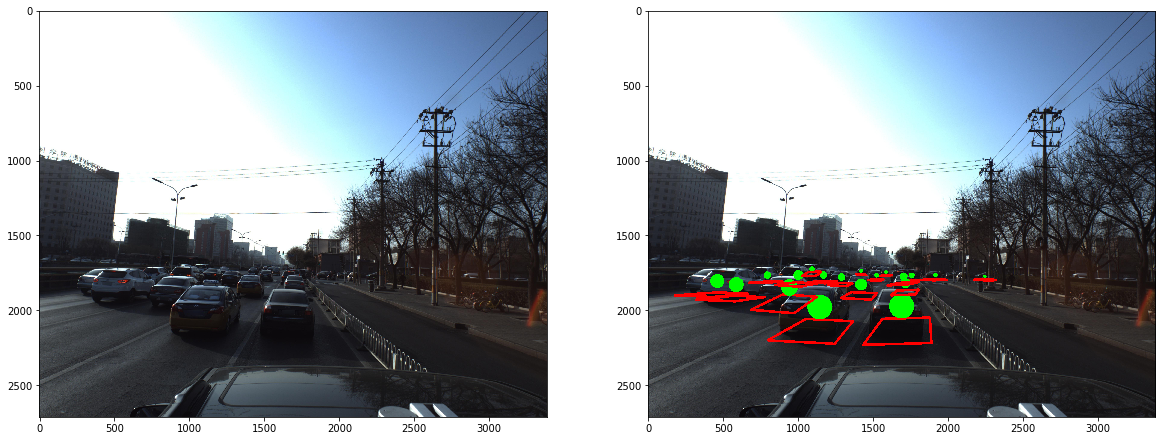

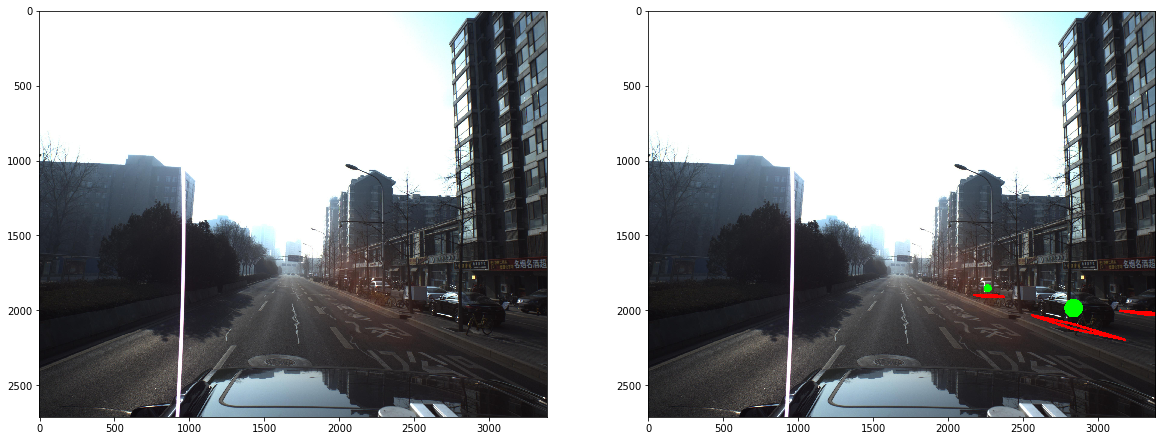

In [20]:
n_rows = 6

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()

# Image preprocessing

In [21]:
IMG_WIDTH = 2052
IMG_HEIGHT = 1036
MODEL_SCALE = 8

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

img.shape (1036, 2052, 3) std: 0.28710958
mask.shape (129, 256) std: 0.012303743
regr.shape (129, 256, 7) std: 0.005202216


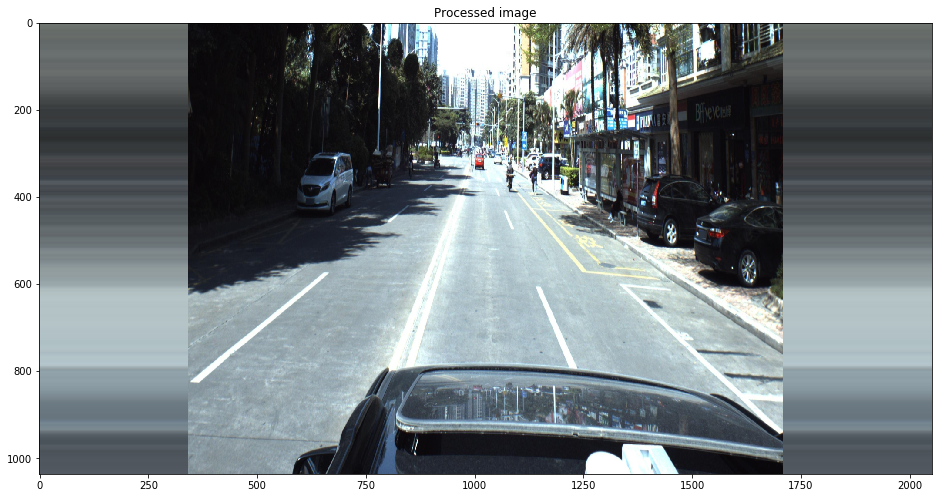

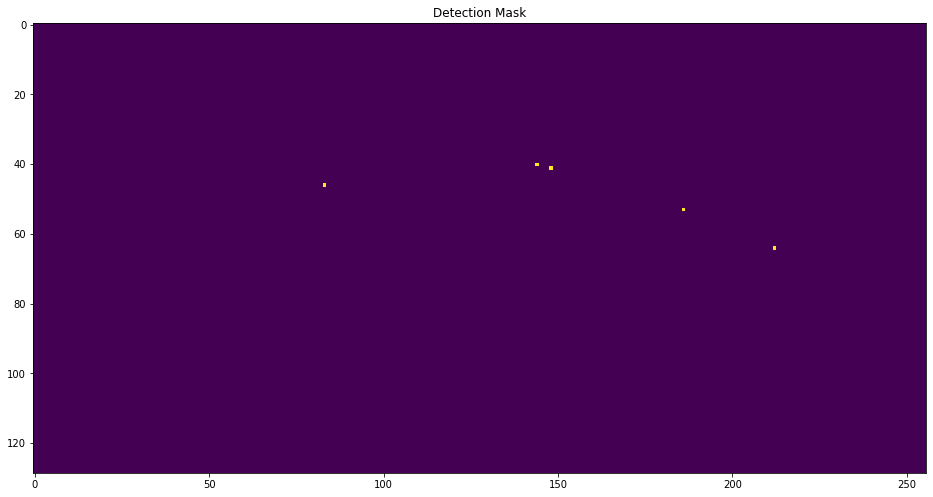

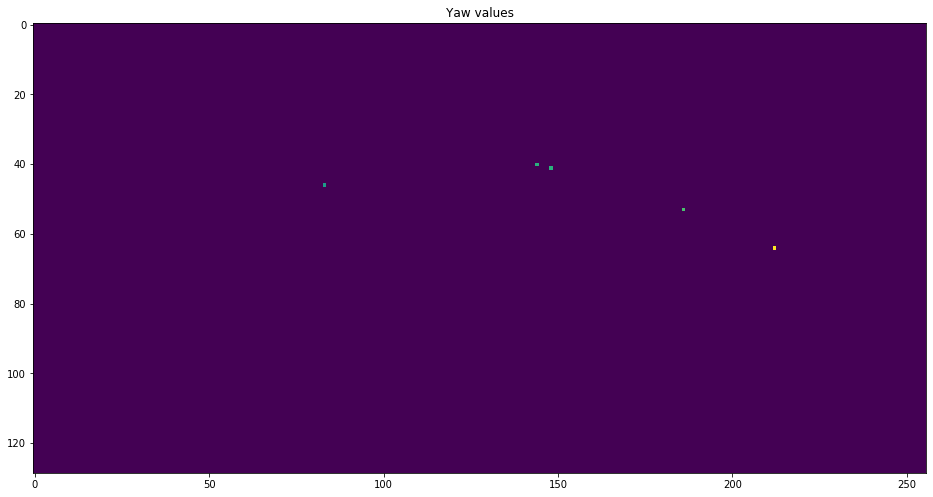

In [22]:
img0 = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

# PyTorch Dataset

In [23]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]

In [24]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

Show some generated examples

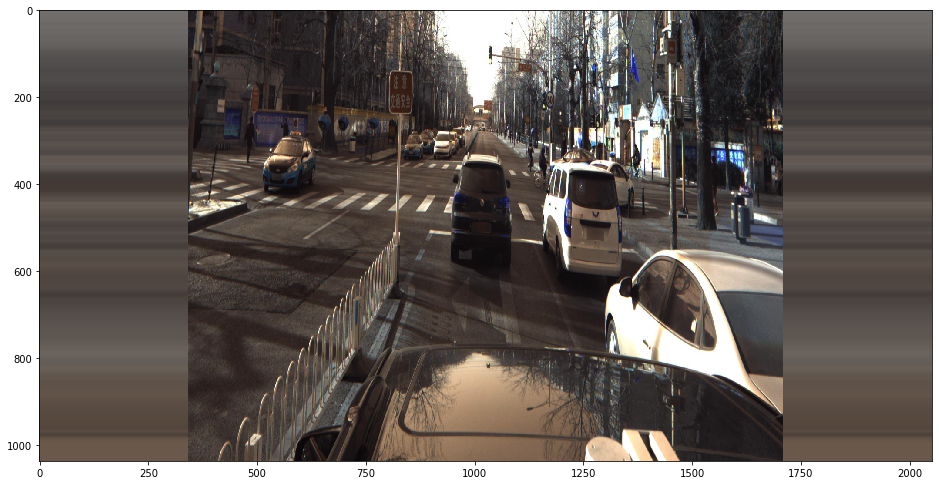

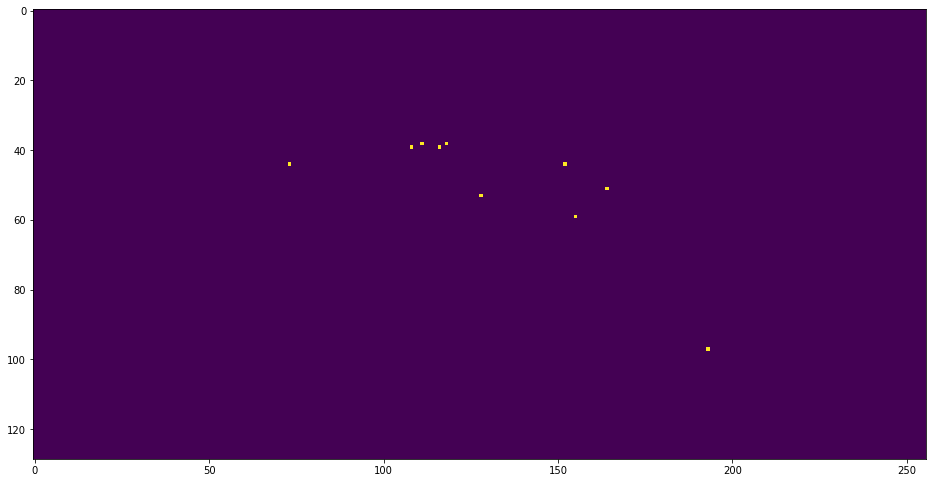

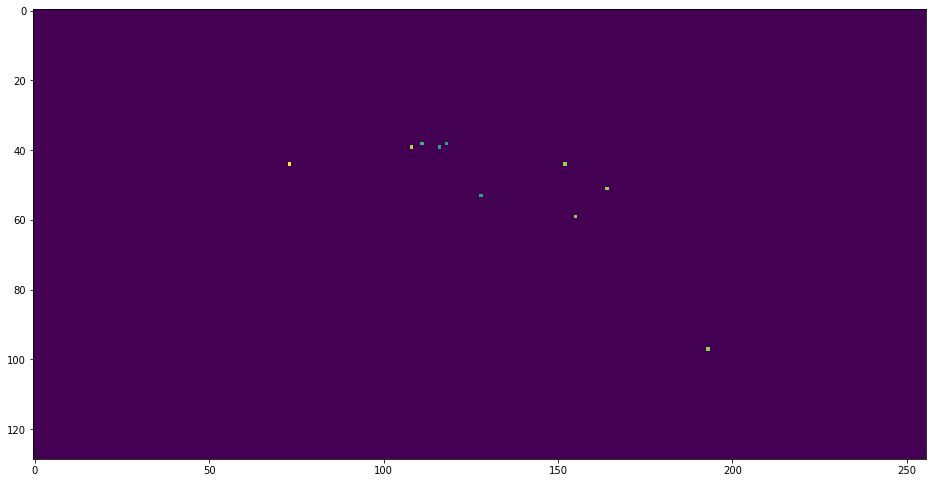

In [25]:
img, mask, regr = train_dataset[0]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [26]:
BATCH_SIZE = 2

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# PyTorch Model

In [27]:
#!pip install efficientnet-pytorch

In [28]:
from efficientnet_pytorch import EfficientNet

In [29]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [30]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        #self.up1 = up(3074, 512)
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        feats = self.base_model.extract_features(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [31]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 16

model = MyUNet(8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda
Loaded pretrained weights for efficientnet-b0


# Training

In [32]:
def criterion(prediction, mask, regr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    # Sum
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [33]:
def train(epoch, history=None):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

In [ ]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)

/home/hy/anaconda3/envs/badeda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
torch.save(model.state_dict(), './b0_sz-2052-1026.pth')

In [ ]:
history['train_loss'].iloc[100:].plot();

In [ ]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

# Visualize predictions

In [ ]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

In [ ]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

for idx in range(8):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

# Make submission

In [ ]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

In [ ]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('b0_sz-2052-1026.csv', index=False)
test.head()